# GLD/GDX - Pair Trading Strategy

This notebook introduces and expands upon the pair trading example of SPDR Gold Trust ETF (**GLD**) and Van Eck Gold Miners ETF (**GDX**) found on pg 63 of Ernest Chan's *Quantitative Trading* to explore potential profitable trading strategies.

## 1. Introduction

Pair trading is a market-neutral strategy that requires going long on one asset and going short another related asset to take advantage of the mean-reverting characteristic of the spread between the two assets. Mathematically, this phenomenon is termed "cointegration," where some linear combination of their prices exhibit weak stationarity, or in other words, that the linear combination's mean and variance do not change over time. We infer here then that this linear combination will be mean-reverting. Therefore, pairs trading attempts to identify points of divergence in the time series of this linear combination (going long on one asset and going short on the other at a ratio equal to the best estimate of their long-term price ratio) and capitalize on the assumption that the relationship will revert back to "normal", or the mean. In this notebook, we explore the relationship between SPDR Gold Trust ETF (**GLD**), which seeks to track the price of gold bullion, and Van Eck Gold Miners ETF (**GDX**), which seeks to track the performance of companies in the gold mining industry, and attempt to devise a pairs trading strategy for the two assets.

## 2. Inputs

Price data of **GLD** and **GDX** are retrieved from Yahoo Finance via the yfinance package. We will have daily OHLC data for the two assets.

In [1]:
from yfinance_data import get_price_df
# Retrieve price data from Yahoo Finance, drop non-price columns, and merge the two assets' data
df = get_price_df('GLD', 'GDX')
# final date variable for consistency when running notebook and using price data
final_date = '2024-04-12'
df = df.loc[df.index <= final_date]

In [2]:
df.head(5)

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX
Date,,,,,,,,
2006-05-22 00:00:00-04:00,64.419998,65.419998,63.799999,65.300003,31.583521,32.249439,31.021381,32.197548
2006-05-23 00:00:00-04:00,65.989998,67.160004,65.910004,66.379997,32.647263,33.918562,32.647263,32.828876
2006-05-24 00:00:00-04:00,64.830002,65.160004,63.220001,64.059998,32.111068,32.491592,31.021383,31.583523
2006-05-25 00:00:00-04:00,64.120003,64.760002,63.759998,64.699997,32.154298,33.140202,31.981332,33.140202
2006-05-26 00:00:00-04:00,65.010002,65.099998,63.750000,65.099998,33.503431,33.503431,32.664547,33.339111


## 3. Methodology

### 3.1 Intuition

As **GDX** represents a basket of gold mining stocks, it is intuitive that the profitability of these companies should be closely related to the price of gold, tracked by **GLD**. Therefore, we conjecture that any divergence between the prices of these two assets (as measured by spread) should not persist and instead converge (i.e., spread goes to zero) in the long-run. We run a OLS regression on the last 5 years of **GLD** prices against **GDX** prices to take an initial look at the evolution of the spread. The estimate of slope, representing the price change in the dependent variable asset per unit change in the price of independent variable asset, naturally provides the best estimate of hedge ratio (if we define best estimate to be the one that minimizes the sum of squared spreads). The regression model is as follows:

\begin{equation}
Y_i = \beta X_i + \epsilon_i
\end{equation}

Note we do not include a constant term in the model as this may allow for the potential of a negative *theoretical* asset price.

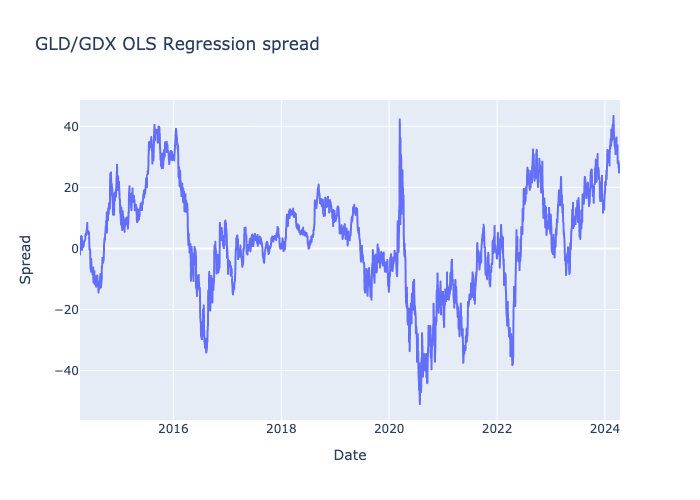

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = 'png'
num_trading_days = 252
num_test_years = 10
df_temp = df.iloc[-num_test_years * num_trading_days:]
Y = df_temp['Close_GLD']
X = df_temp['Close_GDX']
model = sm.OLS(Y, X)
res = model.fit()
hedgeratio = res.params.iloc[0]
spread = df_temp['Close_GLD'] - df_temp['Close_GDX'] * hedgeratio
fig = px.line(spread, title='GLD/GDX OLS Regression spread', labels={'value': 'Spread'})
fig.update_layout(showlegend=False)
# fig.show()
# png renderer picked to render for Github preview, please uncomment above line and comment out below line when using in jupyterlab
fig.show(renderer='png')

The above plot, though not a decisive indicator of the spread possessing mean-reverting property or cointegration in any capacity, would seem to suggest some signs of a potentially mean-reverting spread, albeit the increasing divergence in the most recent data.

For a more rigorous discussion on whether the spread is truly mean-reverting, please see Appendix A on cointegration. This discussion was not included in the main section of the notebook because further work needs to be done validate the credibility of the Python modules that test cointegration. Initial tests have suggested the two assets are, in fact, not cointegrated.

### 3.2 Discussion of Strategy

Under the (rather strong) assumption that the spread between **GLD** and **GDX** is indeed mean-reverting, we attempt to devise a strategy to take advantage of this phenomenon. The strategy takes one year of training data, finds the optimal hedge ratio through OLS regression, which allows for spread calculation over the period. The training period hedge ratio, spread mean, and standard deviation will then be used over the testing period (the entirety of year $t+1$) to generate z-scores of the spread. Based on entry and exit z-score thresholds (parameters for which we attempt to optimize), we will enter or exit on either sides of the spread trade. We discuss the strategy in detail below:

1. Assume we are at the end of year $t$ and that we have a full year's worth of price data for the two assets (which will be our training data). We run a OLS regression on the full years' data of **GLD** prices ($Y_i$) against **GDX** prices ($X_i$) to obtain our best estimate of hedge ratio $\beta$. The regression model is as follows:

\begin{equation}
Y_i = \beta X_i + \epsilon_i
\end{equation}

2. Based on hedge ratio $\beta$, we can calculate the spread of the two assets each day over the training period:

\begin{equation}
spread_i = Y_i - \beta X_i
\end{equation}

3. Now, we calculate training period spread mean $\overline{spread_{tr}}$
and standard deviation of the training period spread standard deviation $Std(spread_{tr})$.

4. After calculating the spread for the testing period using the same $\beta$, we can now calculate the z-score of the spread for each day over the testing period based on the training period spread mean and standard deviation:

\begin{equation}
zscore_i = \dfrac{(spread_i - \overline{spread_{tr}})}{Std(spread_{tr})}
\end{equation}

5. Based on the entry and exit z-score thresholds, we can now generate optimal positions we should be holding. 
For example, entry and exit z-score thresholds may be 1.5 and 0.2 respectively. Let us walk through a scenario to explain entry and exit conditions.


- At the start of our trading (testing) period, we hold no position. 

- If z-score becomes greater than 1.5, our entry threshold, we go short spread. We short 1 share of **GLD** and buy $\beta$ shares of **GDX**. Only when z-score becomes smaller than 0.2, do we exit our short spread.

- Vice versa, if z-score ever becomes smaller than -1.5, our entry threshold on the long spread side, we buy 1 share of **GLD** and short $\beta$ shares of **GDX**. Only when z-score becomes greater than -0.2, do we exit our long spread.

- Once we have exited either our long or short spread (or at the start of the trading period), we should not be holding any position until z-score has reached an absolute value of the entry threshold.

### 3.3 Assumptions

1. For short selling, we assume 200% of the value of the short sale as the margin requirement to test for the strictest of trading conditions. However, there will be no margin call assumptions.
2. We will be 100% invested at any point in which we are holding positions.
3. We will apply a 1-day delay on implementing positions. Hence, yesterday's signal and calculated position will be implemented at today's closing price.
4. We will be able to hold fractional shares.
5. There will be no transaction costs.

### 3.4 Testing Scope

We limit our testing to the past 6 years of data (each year assumed to have 252 trading days). Hence, we will be able to perform 5 years' worth of tests (each test requiring 2 years of data).

In [4]:
num_days_in_year = 252
num_test_years = 10

### 3.5 Parameter Optimization

1. We optimize for the entry and exit z-score thresholds. For entry thresholds, the tested values will be from 1 to 2.6 in increments of 0.2. For exit thresholds, the tested values will be from 0 to 1 in increments of 0.2. Every possible combination (54) of entry and exit threshold will be tested.

In [5]:
import numpy as np
entry_thresholds = np.arange(1, 2.8, 0.2)
exit_thresholds = np.arange(0, 1.1, 0.2)
param_set = [(x, y) for x in entry_thresholds for y in exit_thresholds]

## 4. Execution and Analysis

Below is the execution code that implements our methodology described above and attempts to optimize for our parameters. We will compare our strategy to a simple buy and hold strategy that will hold equal amounts of **GLD** and **GDX**.

In [6]:
from pairs_trade_test import Pairs_trade_test
from pairs_trade_test import extract_curr_df
import pandas as pd

param_dict = {key: [] for key in param_set}
result_df_list = []
buy_and_hold_return_list = []
for i in range(num_test_years):
    
    # extracts the relevant dataframe based on the year we are testing
    curr_df = extract_curr_df(df, num_days_in_year, num_test_years, i)

    # initializes Pairs_trade_test object
    curr_year_test = Pairs_trade_test(curr_df, 'GLD', 'GDX', 'close', num_days_in_year, num_test_years)

    # calculate buy and hold (baseline strategy) return for current year
    buy_and_hold_return = curr_year_test.buy_and_hold_return()
    
    # calculates hedge ratio, spread, and z-score
    curr_year_test.zscore_calculation()

    for params in param_set:
        
        entry_std, exit_std = params
        
        # signal generated based on entry and exit thresholds, and trades executed based on signals
        test_df = curr_year_test.execute_trades(entry_std, exit_std)
        # save test_df to dict with list of dataframes for each parameter pair
        param_dict[params].append(test_df)
        
        # extracts final PnL and counts days the strategy is actively in a trade
        curr_year_test.analyze_performance(test_df, entry_std, exit_std)
        
    curr_year_result_df = pd.DataFrame.from_records(curr_year_test.result_df_rows)
    result_df_list.append(curr_year_result_df)
    buy_and_hold_return_list.append(buy_and_hold_return)

result_df = pd.concat(result_df_list).reset_index(drop=True)

# results grouped by entry and exit threshold pairs and Sharpe ratio calculated for each pair
grouped_df = Pairs_trade_test.process_result_df(result_df)

Below we have organized in a table the top 5 strategies (entry and exit threshold pairs) in terms of Sharpe ratio. The last row shows the performance of the simple buy and hold strategy that holds equal amounts of **GLD** and **GDX**.

In [7]:
Pairs_trade_test.show_top_strategies(grouped_df, buy_and_hold_return_list, num_days_in_year, 5)

,entry_std,exit_std,mean_return,std_return,avg_days_in_trade,sharpe
0,1.0,0.8,0.055297,0.040906,180.8,1.351803
1,1.2,0.8,0.057801,0.043431,169.7,1.330888
2,1.0,1.0,0.050412,0.039014,171.3,1.292130
3,1.2,0.6,0.047256,0.041732,179.1,1.132366
4,1.2,0.4,0.046689,0.042471,186.4,1.099300
5,Buy and Hold,Buy and Hold,0.042052,0.116235,252.0,0.361788


Below we plot the cumulative PnL of the top 5 strategies over the entire testing period. We also plot the simple buy and hold strategy that holds equal amounts of **GLD** and **GDX** for comparison.

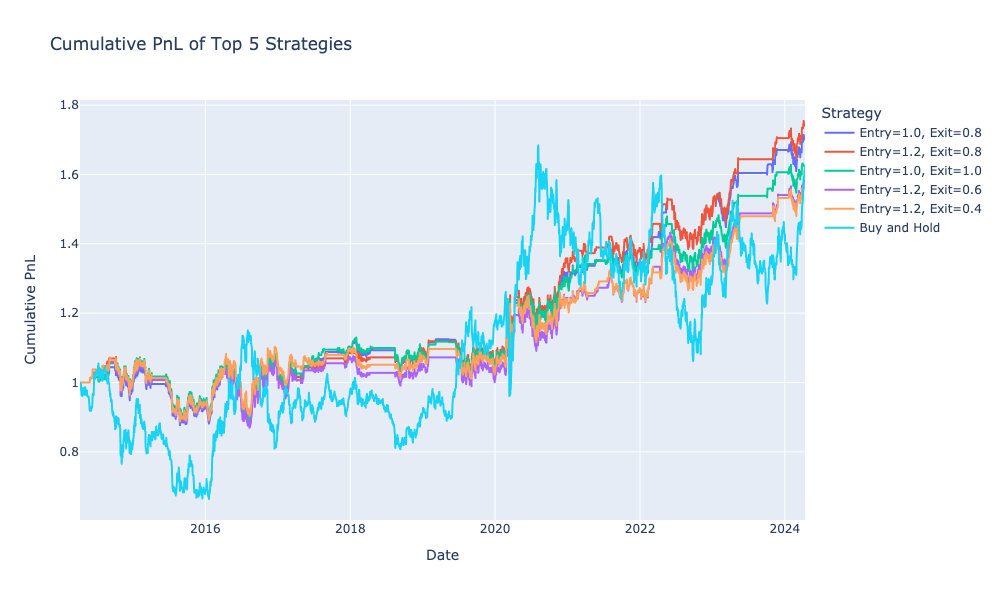

In [10]:
# Pairs_trade_test.plot_top_strategies(grouped_df, param_dict, df, 'GLD', 'GDX', 'close', num_days_in_year, num_test_years, 5)
# png renderer picked to render for Github preview, please uncomment above line and comment out below line when using in jupyterlab
Pairs_trade_test.plot_top_strategies(grouped_df, param_dict, df, 'GLD', 'GDX', 'close', num_days_in_year, num_test_years, 5, 'png')

## 5. Conclusion

The top 5 pairs trading strategies in our test show some promise in their robust historical performance over the past 10 years. Though their mean returns are not much higher than that of the simple buy and hold strategy of both assets, they exhibit much lower standard deviation in their returns. This is evident in the cumulative PnL plot as well. While the pairs trading strategies steadily climb towards 1.5-1.7x mark, the buy and hold strategy experiences much greater drawdowns and much greater gains as it makes its way to a similar mark. The entry and exit thresholds of the optimal strategies tend to be close to each other (the maximum difference between entry and exit z-score being 0.8 for the optimal strategies when the maximum possible is 2.5 for all pairs). This may suggest that if the entry and exit thresholds are too far apart, it may take too long to exit an unprofitable trade. More work needs to be done to understand what factors may cause a tight threshold band to be more profitable than a wide one.

Further work needs to be done in the following regards: 
1. Transaction costs (specifically bid-ask spreads) must be incorporated into the model as this will dampen profitability. The overperformance of the pair trading strategies over the buy and hold strategy is likely overstated currently.
2. Signals can be improved. Instead of using just a fixed number for entry and exit thresholds, it may make sense to combine the threshold with moving averages to assess the momentums of the asset pair before entering and exiting trades.
3. Instead of calculating optimal hedge ratio on a yearly basis, a rolling hedge ratio that updates dynamically could be worth exploring if there is a meaningful change in optimal hedge ratio over time.
4. Paper trading would be valuable to gauge the performance of the strategies in out of sample periods.

## Appendix A. Cointegration

We attempted to examine the cointegration relationship between the two assets over time for our testing period of the last 5 years. However, lack of total familiarity with the concept led to its omission in the main section of the notebook. We attempted to use the cointegration test from the statsmodels module. We also tried a more manual process of testing the two assets first to see if they follow unit root processes (i.e., non-stationary processes which have first differences that are stationary) with the augmented Dickey Fuller test, then running a OLS regression to obtain the spread between the two assets, then test for stationarity of the spread. If the spread indeed followed a stationary process, it would have been evidence of cointegration between the assets. Initial tests suggested, that in fact, the two assets were not cointegrated. Uncertainty over its validity, however, led to its omission.